# 2-Sample tests between groups - Spectrograms

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import os
import mne
from mne.time_frequency import tfr_morlet
import pandas as pd
import scipy.io as io
from numpy import loadtxt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import sklearn.metrics.pairwise as pairwise
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [6]:
import sys
sys.path+=['/data/dian/Dropbox/Stanford_Matters/data/THAL/UMAP',
           '/data/dian/Dropbox/scripts/Stanford/ThalamocoricalLoop-project/utils']
import customFunctions
import statsFunctions
import importlib
importlib.reload(customFunctions)
importlib.reload(statsFunctions)
from customFunctions import *
from statsFunctions import *

In [7]:
os.chdir('/data/dian/Dropbox/Stanford_Matters/data/THAL/CCEP/results/explore5_locked')

In [8]:
metaT = pd.read_csv('table_CCEPnewpipOutput_wholebrain_anatomical_info_activationRedone2.csv')
metaT.head()

,subject,aSubID,block_name,stim_chan,record_chan,sc1,sc2,rc1,rc2,stim_shank,...,pks_time_3,pks_time_4,pks_time_5,pks_time_6,pks_time_7,pks_time_8,pks_time_9,pks_time_10,pks_time_11,pks_time_12
0,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF1-LORF2,LPCN1,LPCN2,LORF1,LORF2,0,...,460.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF2-LORF3,LPCN1,LPCN2,LORF2,LORF3,0,...,442.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF3-LORF4,LPCN1,LPCN2,LORF3,LORF4,0,...,73.0,167.0,476.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF4-LORF5,LPCN1,LPCN2,LORF4,LORF5,0,...,157.0,454.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S21_166_TM,S01_166,E21-725_0010,LPCN1-LPCN2,LORF5-LORF6,LPCN1,LPCN2,LORF5,LORF6,0,...,444.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Activated spectra minus non-activated spectra for each individual

In [9]:
sblist = metaT.subject.unique()
sblist = np.delete(sblist, np.where(sblist=='S23_196_HL'))
print(sblist.shape)
print(sblist)
mat = mergeMat(sblist, keys=['filteridx_metaT','Vrpw','Vrpc', 'Vrph'],
              inputDir = 'UMAP_learn/resample3')
n1=mat['Vrpw'].shape[1]
n2=mat['Vrpc'].shape[1]

(26,)
['S21_166_TM' 'S21_167_MQ' 'S21_169_BH' 'S21_170_JL' 'S21_171_MM'
 'S21_172_KS' 'S22_176_LB' 'S22_177_JM' 'S22_178_AF' 'S22_181_CB'
 'S22_182_DH' 'S22_183_CR' 'S22_185_TW' 'S22_188_CB' 'S22_189_LMA'
 'S22_190_AS' 'S22_192_LG' 'S22_193_AM' 'S23_194_PS' 'S23_195_MZ'
 'S23_197_TA' 'S23_198_JP' 'S23_199_GB' 'S23_201_JG' 'S23_202_KC'
 'S23_205_LLC']


In [10]:
dirbase = '/home/dian/Desktop/THAL/UMAP'
anot = np.array([])
for sb in sblist:
    fn = dirbase+'/WITHINSBJ_semisupervise/actLearn_2clusters_anot_%s.txt' %sb
    content = np.loadtxt(fn).astype(np.int64)
    anot = np.concatenate((anot, content), axis=0)

In [11]:
anot = np.array(anot)
actIdx = np.where(anot == 2)[0] # NOTE: 'anot' is already filteridx_metaT filtered!
noactIdx = np.where(anot == 1)[0]

print(len(actIdx))

dat0 = np.concatenate((mat['Vrpw'], mat['Vrpc']), axis=1)
print(dat0.shape)

# loop through each stimulation channel, to get the activation pattern contracted with the non-activated pattern; 
#i.e. using each channel's non-activation pattern as control
allsublist = metaT['subject'][mat['filteridx_metaT'][:,0]].tolist()
allstimlist = metaT['stim_chan'][mat['filteridx_metaT'][:,0]].tolist()
allstimID = [i+' '+j for i,j in zip(allsublist, allstimlist)]


80791
(249893, 2580)


In [12]:
dat0_res = dat0.copy()
N_noact = [] # each case corresponding to a stimID - check for unstable pattern when the number to average is too low
N_actrate = []
for stimID in set(allstimID):
    stimIdx = set(np.where(np.array(allstimID) == stimID)[0])
    sactIdx = list(stimIdx.intersection(actIdx))
    snonIdx = list(stimIdx.intersection(noactIdx))
    actrate = len(sactIdx)/len(stimIdx)
    
    dat0_res[sactIdx,:] = dat0[sactIdx,:] - np.nanmean(dat0[snonIdx,:], axis = 0) #subtract row vector from matrix
    N_noact.append(len(snonIdx))
    N_actrate.append(actrate)
    

/tmp/ipykernel_3375282/1360297360.py:10: RuntimeWarning: Mean of empty slice
  dat0_res[sactIdx,:] = dat0[sactIdx,:] - np.nanmean(dat0[snonIdx,:], axis = 0) #subtract row vector from matrix


In [13]:
print(dat0_res.shape)
print(len(anot))
print(len(actIdx))
#del dat0

(249893, 2580)
249893
80791


In [14]:
stimID_exclude  = 'S21_167_MQ RE1-RE2'
estimIdx = set(np.where(np.array(allstimID) == stimID_exclude)[0])
esactIdx = estimIdx.intersection(actIdx)
# exclude 'S21_167_MQ RE1-RE2' as it has too few inactivated cases = 5
actIdx = set(actIdx) - esactIdx
actIdx = list(actIdx)
len(actIdx)

80673

In [15]:
# finalize preparing input data and anatomical information
dat = dat0_res[actIdx,:]
filterIdx = mat['filteridx_metaT'][actIdx,0]
T = metaT.iloc[filterIdx,].reset_index()
cleanfilter = (T.sCrossBorder==0) & (T.rCrossBorder==0) & (T.eudDist>5)
# clean data
dat = dat[cleanfilter,:]
T = T.loc[cleanfilter,].reset_index()
# get connectivity information
hemis = list(map(detHemi,
                 T.MNIout_coord_1.tolist(), T.MNIin_coord_1.tolist()
          ))
df = pd.DataFrame({'anatomy_conn': list(map(lambda x,y:'-'.join(str(e) for e in [x,y]),
                  cortexLab(T.JP_label_out.tolist()),
                  cortexLab(T.JP_label_in.tolist()))),#,
                 # metaT.activated.tolist())),
                   'hemis':hemis
                  })
df['anatomy_from'] = cortexLab(T.JP_label_out.tolist())
df['anatomy_to']   = cortexLab(T.JP_label_in.tolist())
df['anatomy_fromTHAL'] = thalLab(T.JP_label_out.tolist())
df['anatomy_toTHAL'] = thalLab(T.JP_label_in.tolist())

crossNet_cat = ['internet','intranet']
df['crossNet_bin'] = list(map(lambda x,y:crossNet_cat[int(x==y)],
                         T.Yeo7_out2, T.Yeo7_in2))
df['crossNet'] = list(map(lambda x,y:'-'.join(str(e) for e in [x,y]),
                         T.Yeo7_out2, T.Yeo7_in2))
df['Hemi-crossNet_bin'] = list(map(lambda x,y:'-'.join(str(e) for e in [x,y]),
                  df['hemis'],
                  df['crossNet_bin']
                         ))
df['anatomy_from-hemi'] = df['anatomy_from'].str.cat(df['hemis'], sep='-')
df['anatomy_conn-hemi'] = df['anatomy_conn'].str.cat(df['hemis'], sep='-')

# exclude some ROIs
excludeROI = np.invert(df['anatomy_conn'].str.contains('others'))
df = df.loc[excludeROI,].reset_index()
print(len(df))
dat = dat[excludeROI,:]

58598


In [16]:
print(dat.shape)

(58598, 2580)


In [17]:
# save input data for future loading
#np.save('UMAP/ALLDATA_semisupervise/input_dat1_untransformed.npy',dat1)

In [18]:
# import results from UMAP supervised training using anatomical information
brainInfo = pd.read_csv('UMAP/ALLDATA_semisupervise/brainInfo.csv')

In [19]:
isnoise = loadtxt('UMAP/ALLDATA_semisupervise/isnoise.txt',
                delimiter="\t")
cleanFeatures = loadtxt('UMAP/ALLDATA_semisupervise/cleanFeatures.txt',
                delimiter="\t",dtype='str')

In [20]:
ftypes = list(set(cleanFeatures))
print(ftypes)

['COR-contr', 'THAL-ipsi', 'COR-ipsi', 'THAL-contr']


### 2-sample cluster permutation test between groups

In [21]:
ftypes

['COR-contr', 'THAL-ipsi', 'COR-ipsi', 'THAL-contr']

In [22]:
it1 = 0
it2 = 1
print('Group1: %s'%(ftypes[it1]))
filterBoolean = (cleanFeatures==ftypes[it1])&( isnoise==0) 
d1_ = dat[filterBoolean]
print(d1_.shape)

print('Group2: %s'%(ftypes[it2]))
filterBoolean = (cleanFeatures==ftypes[it2])&( isnoise==0) 
d2_ = dat[filterBoolean]
print(d2_.shape)
# impute missing data
# Preprocess - simulate nan values, which are few
pipe = make_pipeline(SimpleImputer(strategy="mean"))
d1 = pipe.fit_transform(d1_.copy())
d2 = pipe.fit_transform(d2_.copy())

Group1: COR-contr
(9415, 2580)
Group2: THAL-ipsi
(5209, 2580)


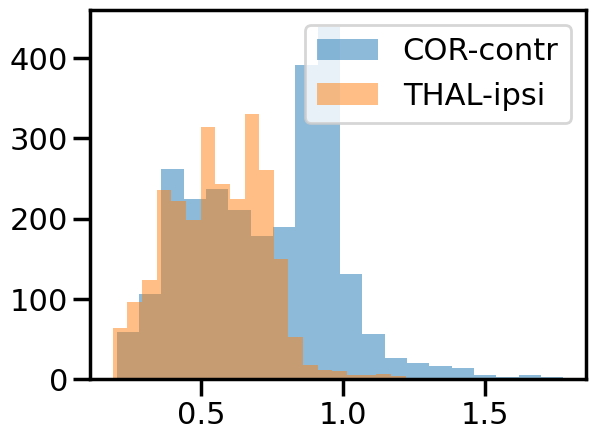

In [23]:
# check variance
var1 = np.var(d1,axis=0)
var2 = np.var(d2,axis=0)
plt.close()
plt.figure()
plt.hist(var1, bins=20, alpha=0.5)
plt.hist(var2, bins=20, alpha=0.5)
plt.legend([ftypes[it1],ftypes[it2]])

In [24]:
ntime = 60
pw1 = d1[:,0:n1].reshape(d1.shape[0], ntime,-1)
pw2 = d2[:,0:n1].reshape(d2.shape[0], ntime,-1)

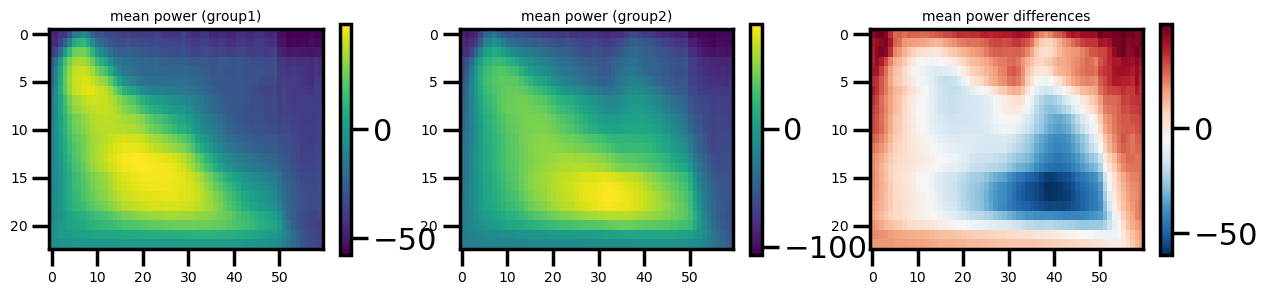

In [25]:
tG1 = tscore_1sample(d1)
tG2 = tscore_1sample(d2)
plotSpectra2Groups(np.rot90(tG1[0:n1].reshape(ntime, -1)),
                   np.rot90(tG2[0:n1].reshape(ntime, -1)))

In [27]:
adjacency = mne.stats.combine_adjacency(
     pw1.shape[1], pw1.shape[2] #  times, freqs
)

#### Compute statistics


In [28]:
# We want a one-tailed test
tail = 0

# In this example, we wish to set the threshold for including data bins in
# the cluster forming process to the t-value corresponding to p=0.001 for the
# given data.
#
# As the degrees of freedom, we specify the number of observations
# (here: epochs) minus 1.
# Finally, we subtract 0.001 from 1, to get the critical t-value
# on the right tail (this is needed for MNE-Python internals)
#degrees_of_freedom = pw1.shape[0] + pw2.shape[0] - 2
#p_threshold = 0.0000001
#thresh = scipy.stats.f.ppf(1 - p_threshold, pw1.shape[0]-1, pw2.shape[0]-1)

# Set the number of permutations to run.
# Warning: 50 is way too small for a real-world analysis (where values of 5000
# or higher are used), but here we use it to increase the computation speed.
n_permutations = 5000

# Run the analysis
F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test(
    [pw1,pw2], n_jobs=-1,
    n_permutations=n_permutations,
    threshold= 500,
    tail=tail,
    adjacency=adjacency,
    out_type="mask",
    verbose=True
)

stat_fun(H1): min=0.001704 max=2737.956124
Running initial clustering …
Found 4 clusters


  0%|          | Permuting : 0/4999 [00:00<?,       ?it/s]

In [ ]:
plt.figure()
plt.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

F_obs_plot = np.nan * np.ones_like(F_obs)
for c, p_val in zip(clusters, cluster_p_values):
    if p_val <= 0.01:
        F_obs_plot[c] = F_obs[c]


t_idx, f_idx = np.unravel_index(
    np.nanargmax(np.abs(F_obs_plot)), pw1.shape[1:]
)

vmax = np.max(np.abs(F_obs))
vmin = -vmax
plt.close()
plt.figure()
plt.imshow(
    np.transpose(F_obs),
    cmap=plt.cm.gray,
   # extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    vmin=vmin,
    vmax=vmax,
)

plt.imshow(
    np.transpose(F_obs_plot),
    cmap=plt.cm.RdBu_r,
 #   extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    vmin=vmin,
    vmax=vmax,
)
plt.colorbar()
plt.xlabel("Time (customized unit)")
plt.ylabel("Frequency (customized unit)")
#plt.title(f"Induced power ({tfr_epochs.ch_names[ch_idx]})")

In [ ]:
# save significant clusters
sigClsts = {"F_obs":F_obs, "clusters":np.array(clusters), "cluster_p_values":cluster_p_values, "H0":H0,
           "F_obs_thr":F_obs_plot, 't_idx':t_idx, 'f_idx':f_idx}
io.savemat("GroupLevel_SigTest/mnePermutationCluster2Sample-Ftest_sigClsts_%s_vs_%s.mat"%(ftypes[it1],ftypes[it2]), 
           sigClsts)